# Cross-spatial neighbourhoods
By clustering the tiles on various selected variables, we can check which places are similar according to those variables.

### 1. Imports and settings. Load the datagrid

In [53]:
import pandas as pd
import numpy as np
import pydeck as pdk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# SETTINGS
# data source
file_grid = "./ehv-grid-apr23.csv" 

def load_data():
    data = pd.read_csv(file_grid)
    print("{} datapoints", len(data)) 
### move everything to the center
    data.lat = data.lat / 1000 +0.0005
    data.lon = data.lon / 1000 +0.0005
    return data


In [54]:
df = load_data()
df.sample(2)

{} datapoints 11832


,lat,lon,Enb.avg_income,Enb.woz,Enbp.high_education,Enbp.independent,Enbp.low_education,Enbp.unemployed,Gcb.buurt,Gcb.buurtcode,...,Vn.PM10_avg_2020,Vn.PM10_avg_2021,Vn.PM10_avg_2022,Vn.med_tree_height,Vn.number_species,Vn.number_tree_species,Vn.number_trees,Vn.prec_ann,Vn.tavg_ann,Vnp.Green
10453,51.4805,5.4595,41.9,265.0,28.9,67.80,29.7,7.0,Woenselse Heide,531,...,NaN,NaN,NaN,21.0,NaN,3.0,20.0,64.583333,10.11908,0.384983
10544,51.4815,5.4325,62.7,454.0,38.4,78.59,23.5,2.0,Kerkdorp Acht,521,...,NaN,NaN,NaN,16.5,NaN,5.0,40.0,64.583333,10.11908,0.069846


### 2. Tile Clustering
#### 2.1 Choose the variables 
Which variables do we care about?

In [55]:
print("All vars: ", df.columns.values)

All vars:  ['lat' 'lon' 'Enb.avg_income' 'Enb.woz' 'Enbp.high_education'
 'Enbp.independent' 'Enbp.low_education' 'Enbp.unemployed' 'Gcb.buurt'
 'Gcb.buurtcode' 'Inp.Grey' 'Pnb.cohesion' 'Pnb.diversity' 'Pnb.good_life'
 'Pnb.pop' 'Pnbp.complains_aq' 'Pnbp.complains_noise' 'Pnbp.feels_unsafe'
 'Pnbp.mostly_by_car' 'Pnbp.mostly_walking' 'Pnbp.unhappy' 'Vc.milieuzone'
 'Vc.mode_species' 'Vc.mode_tree_species' 'Vn.PM10_avg_2020'
 'Vn.PM10_avg_2021' 'Vn.PM10_avg_2022' 'Vn.med_tree_height'
 'Vn.number_species' 'Vn.number_tree_species' 'Vn.number_trees'
 'Vn.prec_ann' 'Vn.tavg_ann' 'Vnp.Green']


In [56]:
# VARS_TO_USE = ['Pnb.pop', 'Vnp.Green', 'Inp.Grey']

VARS_TO_USE = ['Pnb.pop', 'Enb.woz','Pnb.cohesion']

x = df[VARS_TO_USE + ['lat','lon']].copy() # keep lat, lon only for visualizations
x.dropna(inplace=True)
print("Keeping the {} tiles (out of {}) where all interesting vars are defined.".format(len(x),len(df)))

Keeping the 6704 tiles (out of 11832) where all interesting vars are defined.


#### 2.2 Preprocessing

In [57]:
# TODO: remove OUTLIERS ?
# TODO: accomodate category variables? they should be encoded 

# SCALE
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x[VARS_TO_USE])

# statistics of scaled data
pd.DataFrame(x_scaled).describe()

,0,1,2
count,6.704000e+03,6.704000e+03,6.704000e+03
mean,3.391612e-17,-6.359273e-17,6.571248e-16
std,1.000075e+00,1.000075e+00,1.000075e+00
min,-1.763606e+00,-1.000617e+00,-2.322461e+00
25%,-7.226970e-01,-7.013591e-01,-8.716291e-01
50%,-4.610647e-02,-4.293061e-01,9.559195e-02
75%,6.304841e-01,5.840910e-01,5.792025e-01
max,3.024574e+00,3.923541e+00,2.352441e+00


#### 2.3 K-means clustering. Finding the best K

In [58]:
kmeans = KMeans(3,n_init=10)
kmeans.fit(x_scaled)

clust = kmeans.fit_predict(x_scaled)
x['Clusters'] = clust
### plt.scatter(x['lon'],x['lat'],c=x['Clusters'],marker='.',cmap='rainbow',s=2);

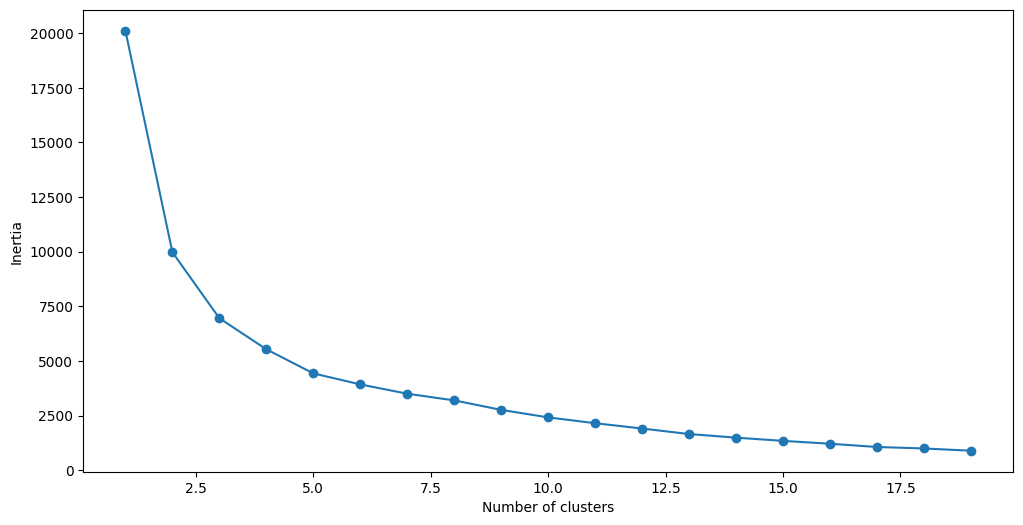

In [59]:
# ELBOW
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, n_init=10, init='k-means++')
    kmeans.fit(x_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

#### 2.4 K-means with best K. Evaluation. Formulate cluster descriptions

In [60]:

K_BEST = 3 # <- fill in from the elbow chart # TODO: compute K_BEST automatically

kmeans = KMeans(K_BEST,n_init=10)
kmeans.fit(x_scaled)

clust = kmeans.fit_predict(x_scaled)
x['Clusters'] = clust
### plt.scatter(x['lon'],x['lat'],c=x['Clusters'],cmap='rainbow',s=1);

In [61]:
# check for cluster balance
x['Clusters'].value_counts()

2    2651
0    2490
1    1563
Name: Clusters, dtype: int64

In [62]:
# calculate cluster statistics
for i in range(kmeans.n_clusters):
    cluster_data = x[x['Clusters'] == i]
    explanation ="on average, "
    for v in set(VARS_TO_USE):
        explanation = explanation + v + " " + str(round(cluster_data[v].mean(),2)) + " "
    print('Cluster {}: {} tiles - {}'.format(i,len(cluster_data), explanation))

# evaluate cluster quality
from sklearn.metrics import silhouette_score
print('Silhouette score: {}'.format(silhouette_score(x_scaled, clust)))

Cluster 0: 2490 tiles - on average, Pnb.pop 53.94 Pnb.cohesion 5.58 Enb.woz 247.93 
Cluster 1: 1563 tiles - on average, Pnb.pop 12.87 Pnb.cohesion 6.85 Enb.woz 558.07 
Cluster 2: 2651 tiles - on average, Pnb.pop 32.49 Pnb.cohesion 6.25 Enb.woz 313.39 
Silhouette score: 0.3825191627200911


In [63]:
def noPrefix(s):
    return s.split(".")[1] 


In [64]:
# summarize the clusters
## VARS_TO_USE = removePrefix (VARS_TO_USE)

x_sum=pd.DataFrame(columns = VARS_TO_USE + ['explanation','short'])
for i in range(kmeans.n_clusters):
    cluster_data = x[x['Clusters'] == i]
    explanation ="on average, "
    for v in set(VARS_TO_USE):
        x_sum.loc[i,v] = cluster_data[v].mean()
        explanation = explanation + noPrefix(v) + " " + str(round(cluster_data[v].mean(),2)) + " "
        x_sum[v] = x_sum[v].astype(float)
    x_sum.loc[i,'explanation'] = explanation
    x_sum.loc[i,'short'] = ""

for v in set(VARS_TO_USE):
    imin = x_sum[v].idxmin()
    x_sum.loc[imin,'short'] = x_sum.loc[imin,'short'] + "least " + noPrefix(v) + " "
    imax = x_sum[v].idxmax()
    x_sum.loc[imax,'short'] = x_sum.loc[imax,'short'] + "most " + noPrefix(v) + " "
    # TODO if more than 3, also look at the second min and max, use "less" and "more" as qualifications

for i in range(kmeans.n_clusters):   
    if x_sum.loc[i,'short'] == "":
        x_sum.loc[i,'short'] = "no extremes"

x_sum.head()

,Pnb.pop,Enb.woz,Pnb.cohesion,explanation,short
0,53.942570,247.931727,5.579301,"on average, pop 53.94 cohesion 5.58 woz 247.93",most pop least cohesion least woz
1,12.873321,558.067818,6.845617,"on average, pop 12.87 cohesion 6.85 woz 558.07",least pop most cohesion most woz
2,32.493776,313.385515,6.252395,"on average, pop 32.49 cohesion 6.25 woz 313.39",no extremes


#### 2.5 Visualization

In [65]:
import plotly.graph_objects as go


# build the plot
traces=[]
for i in range(kmeans.n_clusters):
    cluster_data = x[x['Clusters'] == i]
#    explanation = cluster_data['explanation']
    print('Cluster {}: {} tiles - {}'.format(i,len(cluster_data), x_sum.loc[i,'short']))
    traces.append(go.Scatter(x=cluster_data['lon'], y=cluster_data['lat'], mode='markers', marker_size=4, name=x_sum.loc[i,'short']))


Cluster 0: 2490 tiles - most pop least cohesion least woz 
Cluster 1: 1563 tiles - least pop most cohesion most woz 
Cluster 2: 2651 tiles - no extremes


In [66]:

# create the figure with all traces and a legend
fig = go.Figure(data=traces)
fig.update_layout(title='new eindhoven :-)')
fig.update_layout(height=500, width=800)
fig.update_xaxes(scaleanchor="y", scaleratio=0.8)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

In [67]:
# TODO: vis on the actual map, with folium

## 3. All in one function
To make this functionality available on a webapp, the cluster analysis needs to be automatized a bit more.

In [68]:
def TileClusters(df,VARS_TO_USE):
    #TODO
    cluster_data = []
    cluster_summary = []
    return cluster_data, cluster_summary
